Initialising particles...
Diffusing particles...
[⏱️] Time to computeModelRegressors(): 3.93 seconds
Computing SS...
Inverting SS...
Computing meanZ
Done
[⏱️] Time to computeZDistribution(): 0.70 seconds
Initialising particles...
Particle shape:
(5, 108000, 3)
Diffusing particles...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
[⏱️] Time to computeConcentration(): 45.14 seconds
[✅] Total source inference pipeline took 49.76 seconds


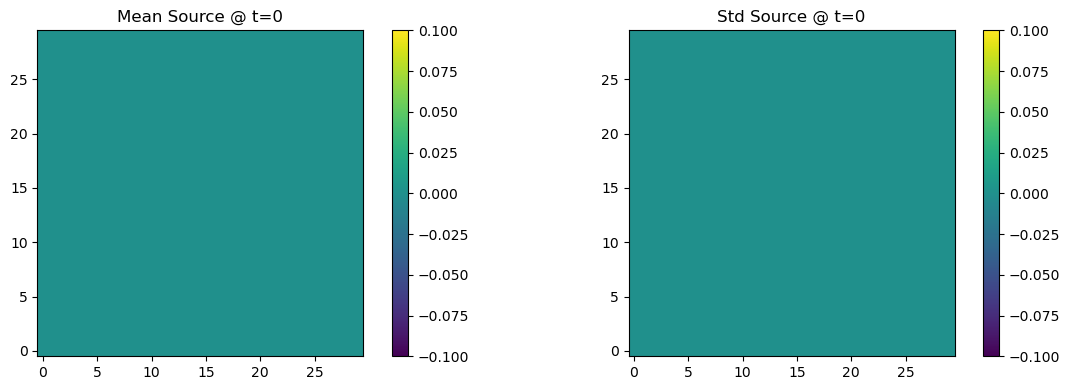

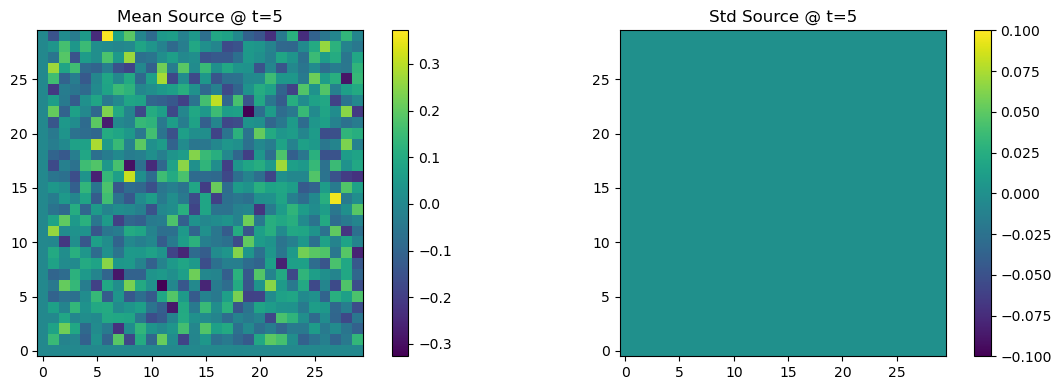

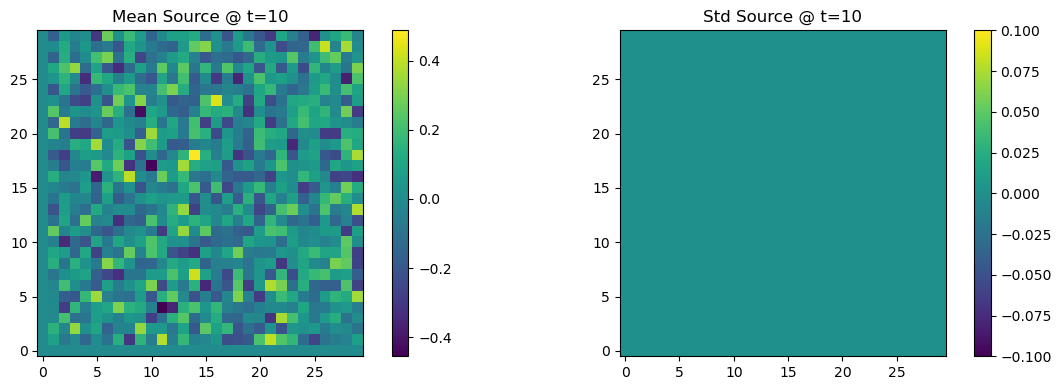

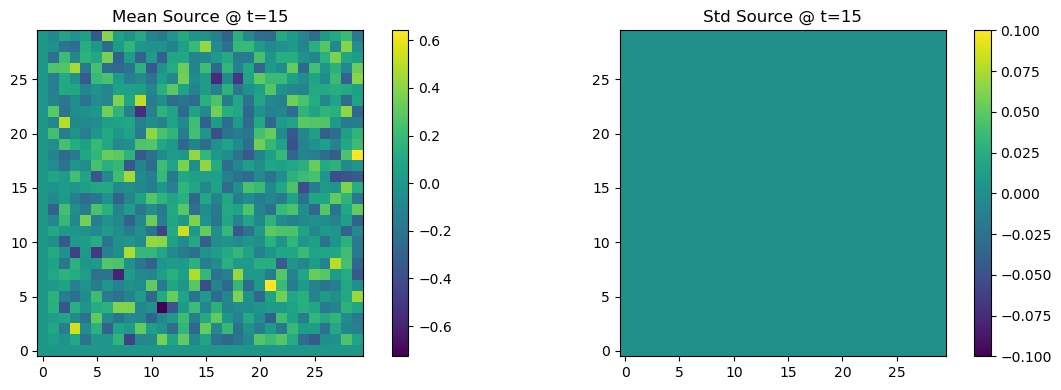

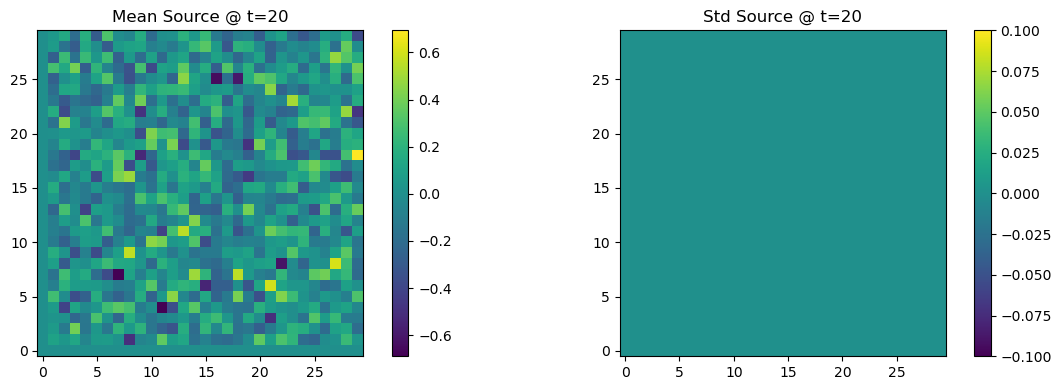

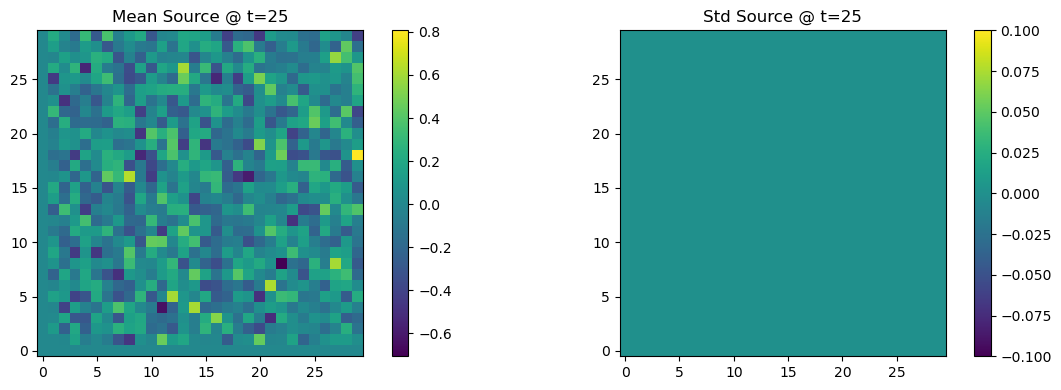

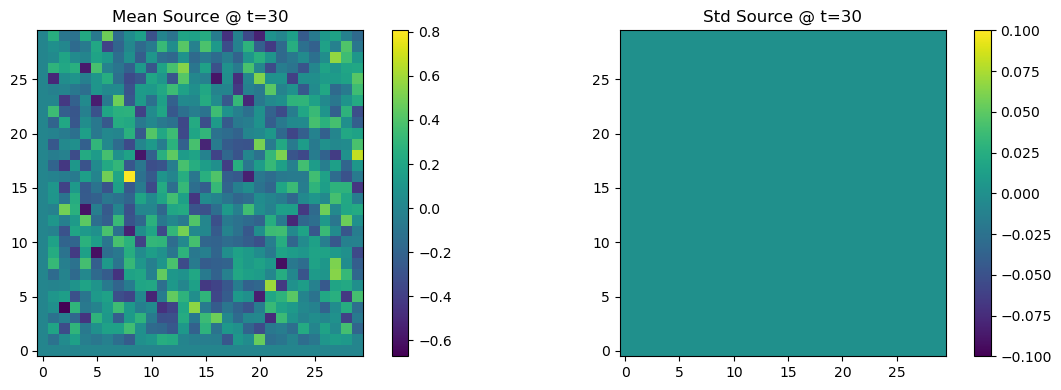

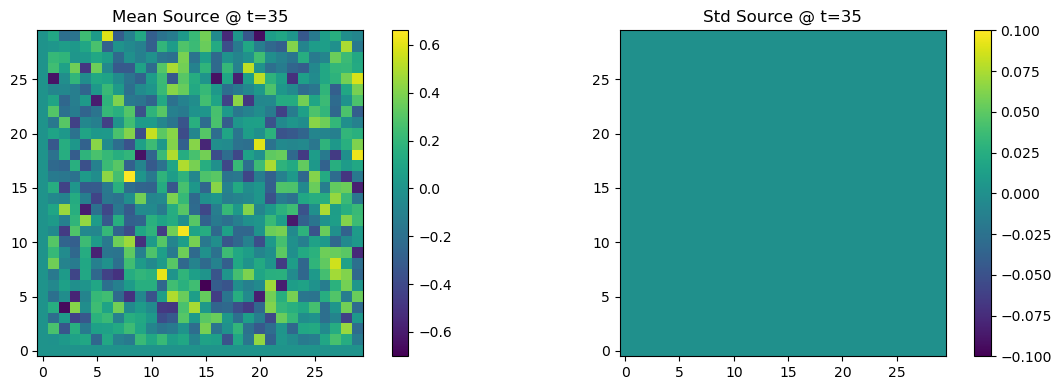

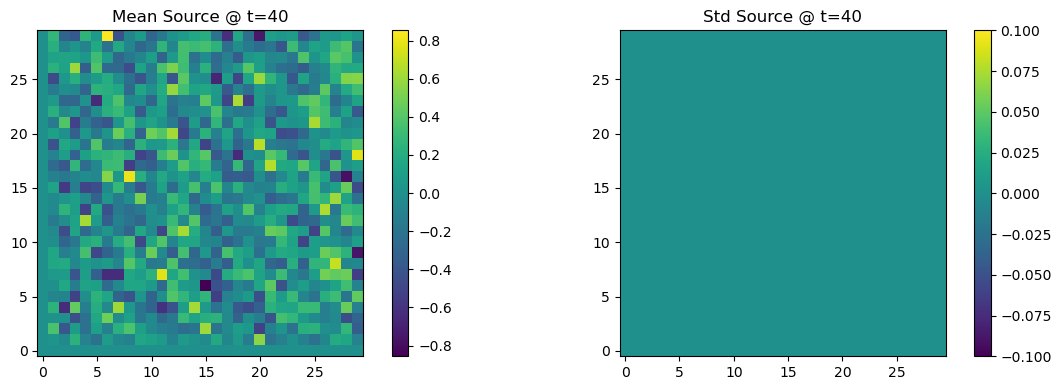

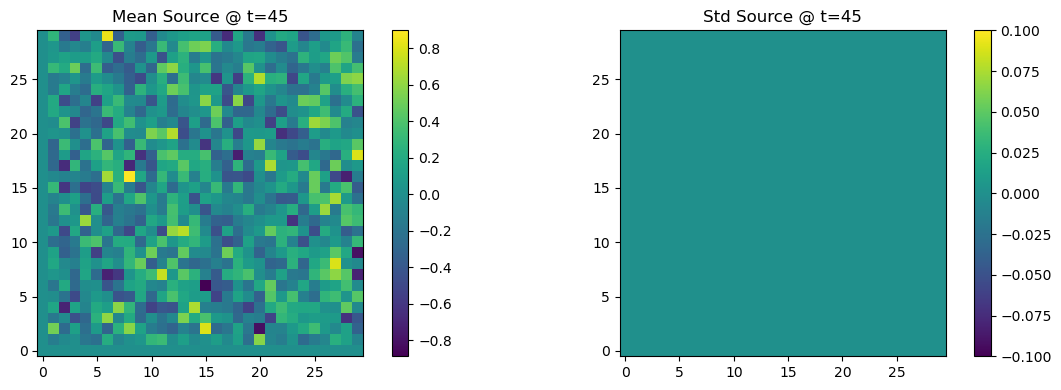

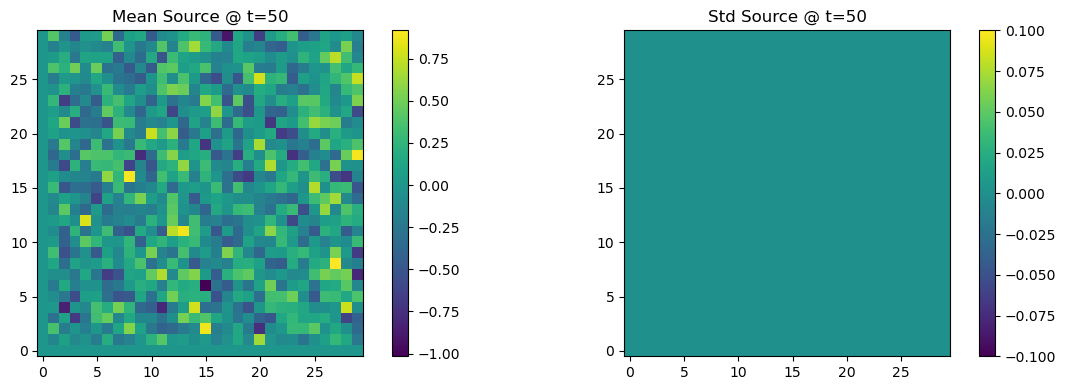

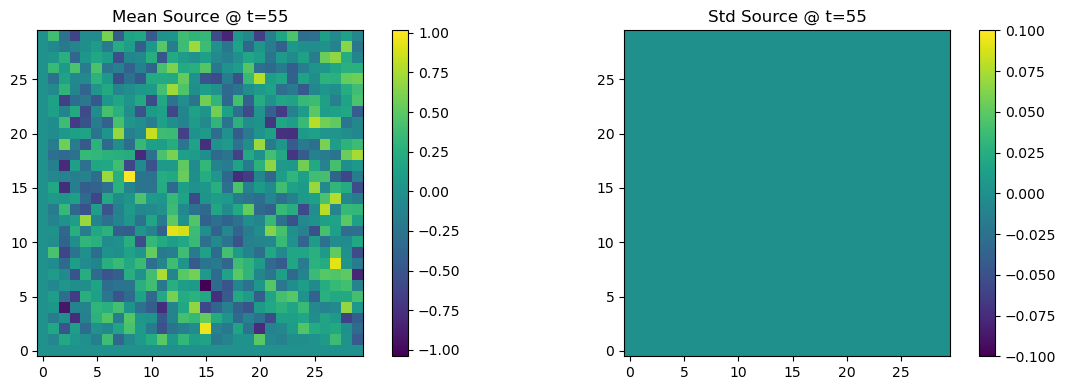

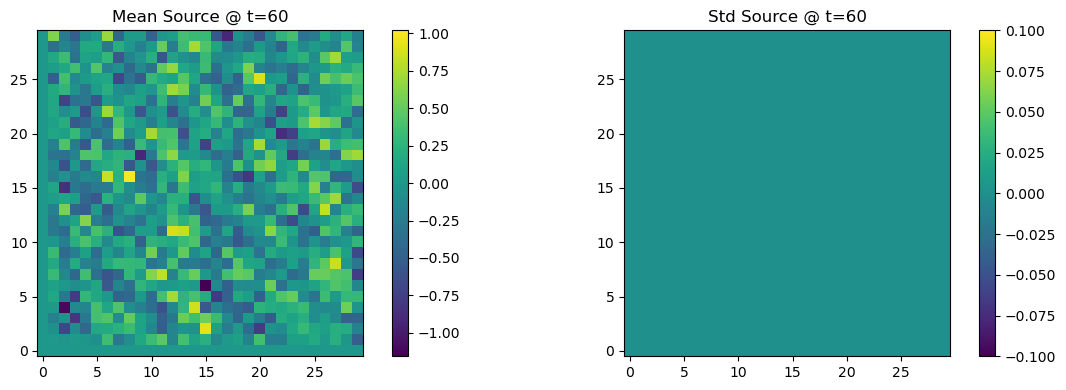

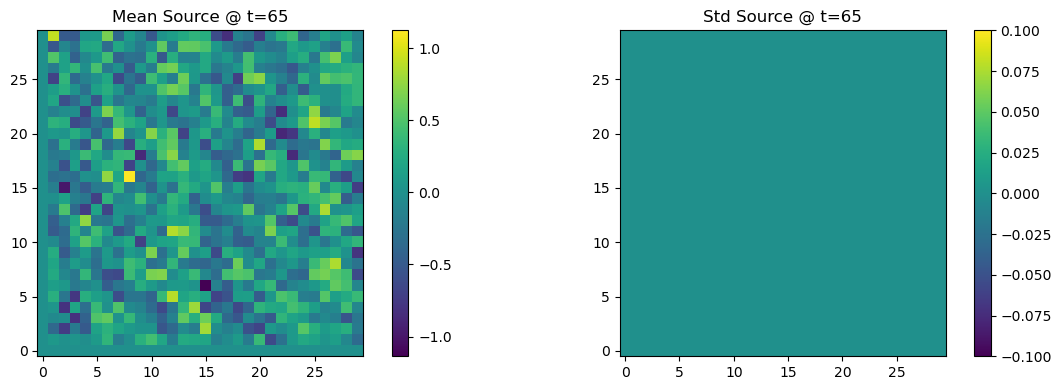

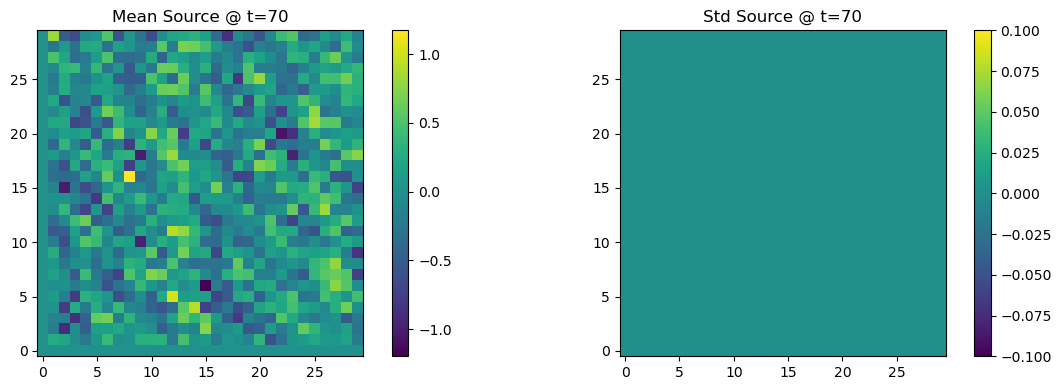

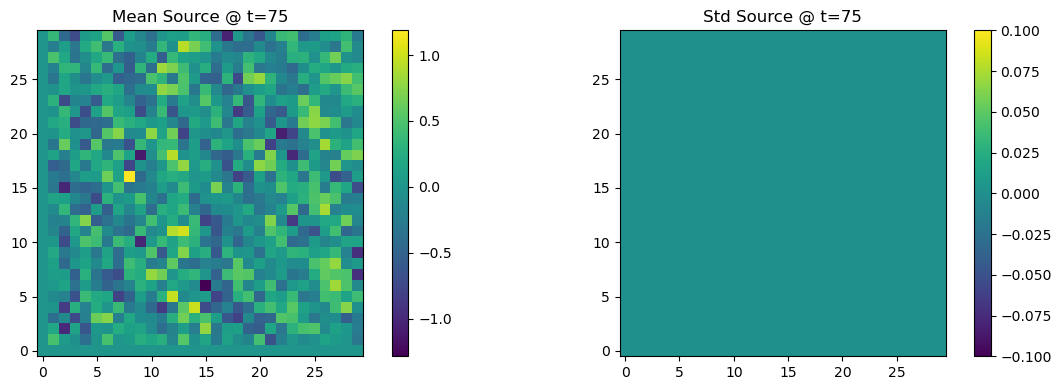

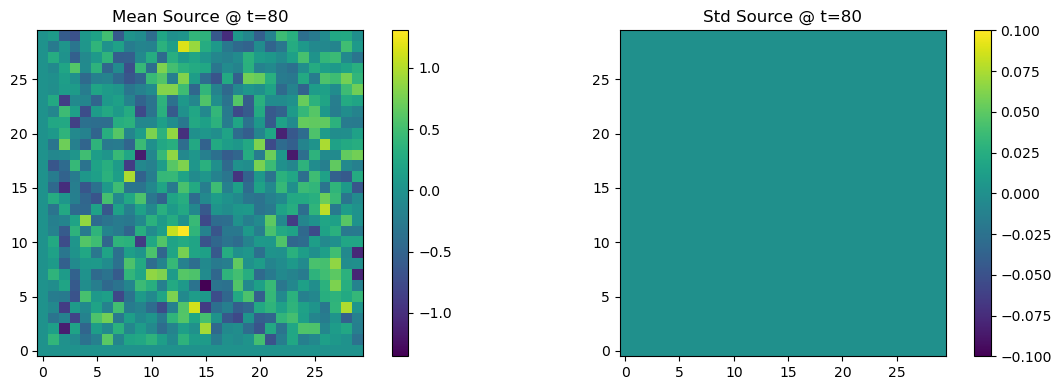

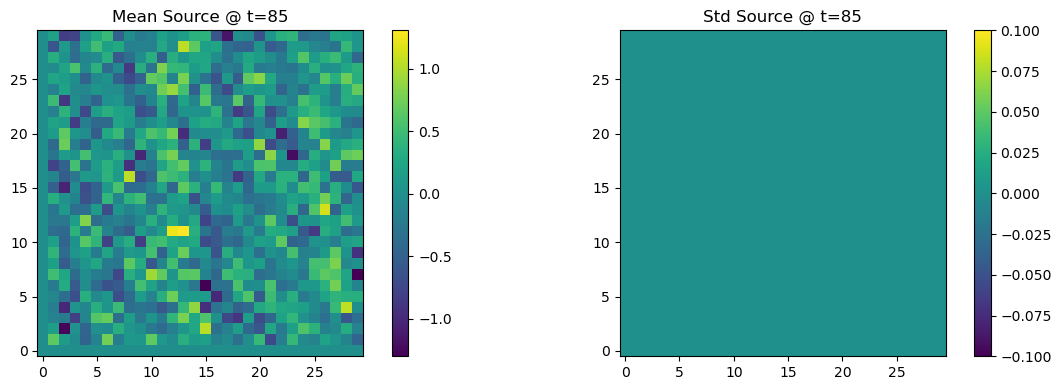

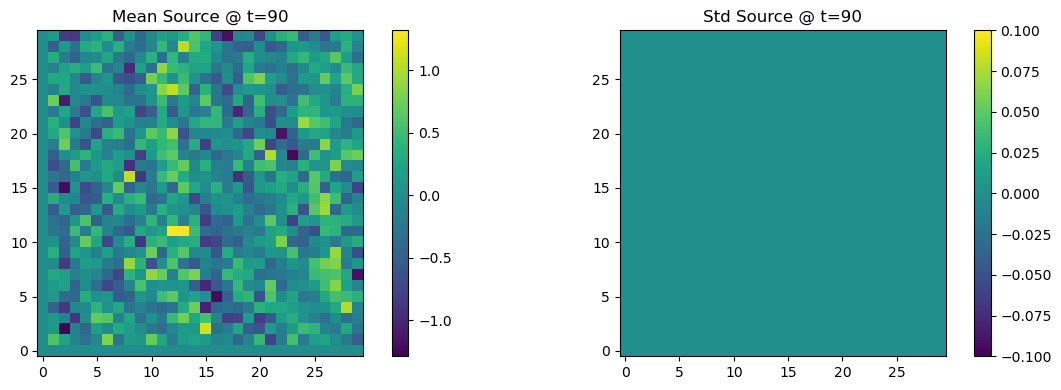

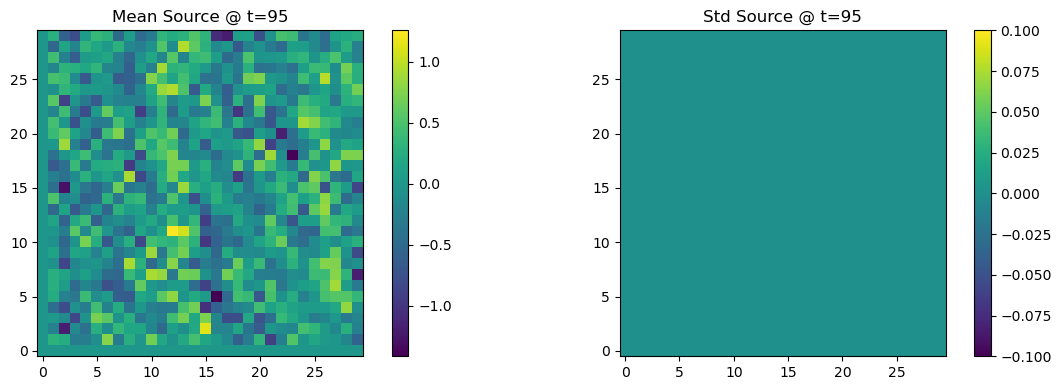

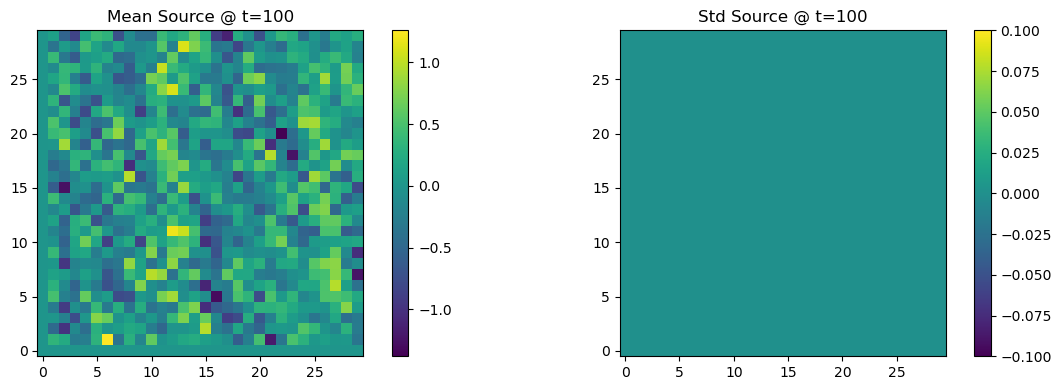

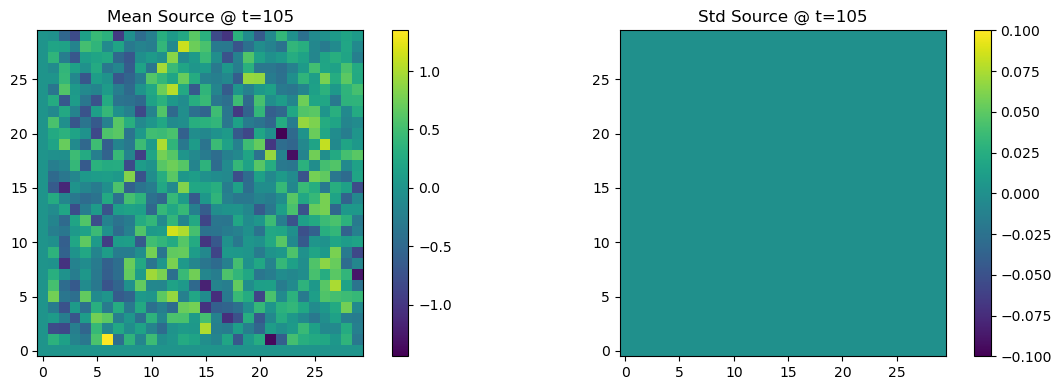

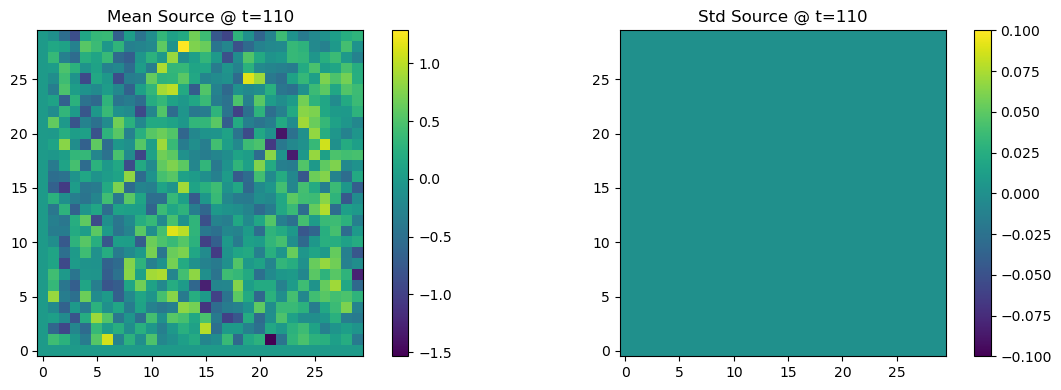

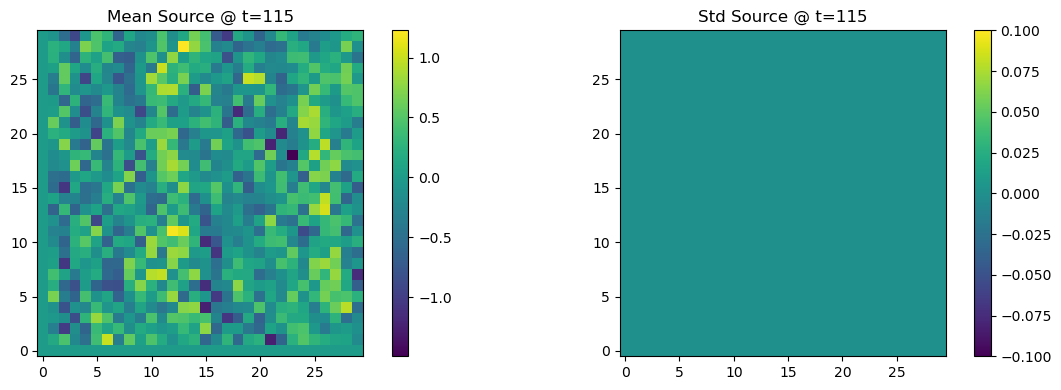

In [6]:
from pyproj import Proj
import numpy as np
from scipy.stats import norm
from advectionGP.kernels import EQ
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.wind import WindSimple, RealWindBinned, RealWindNearestNeighbour
from advectionGP.sensors import RemoteSensingModel
from advectionGPdatasets import proposeboundary
import matplotlib.pyplot as plt
import time

# === Step 1: Define UTM and Spatial Domain ===
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
xmin, ymin = proj(146, -38)
xmax, ymax = proj(148, -36)

# === Step 2: Generate Observation Locations ===
# Create evenly spaced 5 x-centers and 10 y-centers in UTM space
x_centers = np.linspace(xmin, xmax, 5)
y_centers = np.linspace(ymin, ymax, 10)

# Set time range for each observation (last 3 hours of the day)
t_start, t_end = 600, 1440
sensors = RemoteSensingModel(num_particles=3)
# Generate obsLocs as [t_start, t_end, x, y] combinations (shape = 50, 4)
obsLocs = []
for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    obsLocs.append([t_start, t_end, x, y])

obsLocs = np.array(obsLocs)

boundary = proposeboundary(obsLocs)
padding = 50000
boundary = (np.array(boundary[0]), np.array(boundary[1]))
boundary[0][1:] -= padding
boundary[1][1:] += padding

# === Step 3: Sensor Model (no longer needs getHs) ===
# sensors = RemoteSensingModel(num_particles=10)

# === Step 4: Setup Kernel & Wind ===
N_feat = 1500
k = EQ(10, 1)
res = [120, 30, 30]
noiseSD = 0.001
k_0 = 0.5
# windmodel = RealWindCinne(start_date="2019-10-01", num_days=1)
windmodel = WindSimple(1, 1)

# === Step 5: Initialize Mesh-Free Model ===
mInfer = Model(
    resolution=res,
    boundary=boundary,
    N_feat=N_feat,
    noiseSD=noiseSD,
    kernel=k,
    sensormodel=sensors,
    windmodel=windmodel,
    k_0=k_0
)

# === Step 6: Generate Regressor Matrix ===
start_time = time.time()
mInfer.computeModelRegressors()
num_obs = mInfer.X.shape[1]
regressor_time = time.time()
print(f"[⏱️] Time to computeModelRegressors(): {regressor_time - start_time:.2f} seconds")

# === Step 7: Generate Synthetic Observations ===
def generate_Y_from_obsLocs(obsLocs, centre_x, centre_y, D=2e7):
    Y = []
    for t_start, t_end, x, y in obsLocs:
        t = (t_start + t_end) / 2.0
        d = np.linalg.norm([x - centre_x, y - centre_y])
        
        # Clip blobsize to avoid extreme values
        blobsize = np.sqrt(2 * 2 * D * (t + 4))
        blobsize = np.clip(blobsize, 1, 1e6)
        
        try:
            spatial = norm(0, blobsize).pdf(d)
            temporal = norm(600, 300).cdf(t)  # Change from norm(10,1) to something meaningful
            v = 1000 * spatial * temporal / blobsize
        except:
            v = 0.0  # fallback if anything breaks
        
        if not np.isfinite(v):  # guard against nan/inf
            v = 0.0
        Y.append(v)
    
    return np.array(Y)


centre_x = (xmin + xmax) / 2
centre_y = (ymin + ymax) / 2
Y = generate_Y_from_obsLocs(obsLocs[:num_obs], centre_x, centre_y, D=2e7)
Y = Y.reshape(-1)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
# === Step 8: Inference ===
meanZ, covZ = mInfer.computeZDistribution(Y)
inference_time = time.time()
print(f"[⏱️] Time to computeZDistribution(): {inference_time - regressor_time:.2f} seconds")

# === Step 9: Grid Setup for Visualization ===
t_vals = np.linspace(boundary[0][0], boundary[1][0], res[0])
x_vals = np.linspace(boundary[0][1], boundary[1][1], res[1])
y_vals = np.linspace(boundary[0][2], boundary[1][2], res[2])
coords = np.stack(np.meshgrid(t_vals, x_vals, y_vals, indexing='ij'), axis=-1)
coords = coords.reshape(-1, 3)

# === Step 10: Forward Simulation ===
sourcemean, sourcevar, all_samples = mInfer.computeConcentration(
    meanZ=meanZ,
    covZ=covZ,
    Nsamps=1,
    Nparticles=5,
    coords=coords,
    interpolateSource=True
)
forward_time = time.time()
print(f"[⏱️] Time to computeConcentration(): {forward_time - inference_time:.2f} seconds")
# === Total Pipeline Timing ===
print(f"[✅] Total source inference pipeline took {forward_time - start_time:.2f} seconds")

# === Step 11: Plotting ===
sourcemean = sourcemean.reshape(res)
sourcevar = sourcevar.reshape(res)
total_time_seconds = boundary[1][0] - boundary[0][0]
dt_seconds = total_time_seconds / res[0]
step_interval = int(10800 / dt_seconds)

for t_index in range(0, res[0], 5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Mean Source @ t={t_index}")
    plt.imshow(sourcemean[t_index], origin='lower')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"Std Source @ t={t_index}")
    plt.imshow(np.sqrt(sourcevar[t_index]), origin='lower')
    plt.colorbar()
    plt.tight_layout()
    plt.show()



In [1]:
from pyproj import Proj
import numpy as np
from scipy.stats import norm
from advectionGP.kernels import EQ
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.wind import WindSimple, RealWindBinned, RealWindNearestNeighbour
from advectionGP.sensors import RemoteSensingModel
from advectionGPdatasets import proposeboundary
import matplotlib.pyplot as plt
import time

# === Step 1: Define UTM and Spatial Domain ===
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
xmin, ymin = proj(146, -38)
xmax, ymax = proj(148, -36)

# === Step 2: Generate Observation Locations ===
# Create evenly spaced 5 x-centers and 10 y-centers in UTM space
x_centers = np.linspace(xmin, xmax, 5)
y_centers = np.linspace(ymin, ymax, 10)

# Set time range for each observation (last 3 hours of the day)
t_start, t_end = 600, 1440
sensors = RemoteSensingModel(num_particles=3)
# Generate obsLocs as [t_start, t_end, x, y] combinations (shape = 50, 4)
obsLocs = []
for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    obsLocs.append([t_start, t_end, x, y])

obsLocs = np.array(obsLocs)

boundary = proposeboundary(obsLocs)
padding = 50000
boundary = (np.array(boundary[0]), np.array(boundary[1]))
boundary[0][1:] -= padding
boundary[1][1:] += padding

# === Step 3: Sensor Model (no longer needs getHs) ===
# sensors = RemoteSensingModel(num_particles=10)

# === Step 4: Setup Kernel & Wind ===
N_feat = 1500
k = EQ(10, 1)
res = [120, 30, 30]
noiseSD = 0.001
k_0 = 0.5
windmodel2 = RealWindBinned(start_date="2019-10-01", num_days=1)
# windmodel = WindSimple(1, 1)

# === Step 5: Initialize Mesh-Free Model ===
mInfer = Model(
    resolution=res,
    boundary=boundary,
    N_feat=N_feat,
    noiseSD=noiseSD,
    kernel=k,
    sensormodel=sensors,
    windmodel=windmodel2,
    k_0=k_0
)

# === Step 6: Generate Regressor Matrix ===
start_time = time.time()
mInfer.computeModelRegressors()
num_obs = mInfer.X.shape[1]
regressor_time = time.time()
print(f"[⏱️] Time to computeModelRegressors(): {regressor_time - start_time:.2f} seconds")

# === Step 7: Generate Synthetic Observations ===
def generate_Y_from_obsLocs(obsLocs, centre_x, centre_y, D=2e7):
    Y = []
    for t_start, t_end, x, y in obsLocs:
        t = (t_start + t_end) / 2.0
        d = np.linalg.norm([x - centre_x, y - centre_y])
        
        # Clip blobsize to avoid extreme values
        blobsize = np.sqrt(2 * 2 * D * (t + 4))
        blobsize = np.clip(blobsize, 1, 1e6)
        
        try:
            spatial = norm(0, blobsize).pdf(d)
            temporal = norm(600, 300).cdf(t)  # Change from norm(10,1) to something meaningful
            v = 1000 * spatial * temporal / blobsize
        except:
            v = 0.0  # fallback if anything breaks
        
        if not np.isfinite(v):  # guard against nan/inf
            v = 0.0
        Y.append(v)
    
    return np.array(Y)


centre_x = (xmin + xmax) / 2
centre_y = (ymin + ymax) / 2
Y = generate_Y_from_obsLocs(obsLocs[:num_obs], centre_x, centre_y, D=2e7)
Y = Y.reshape(-1)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
# === Step 8: Inference ===
meanZ, covZ = mInfer.computeZDistribution(Y)
inference_time = time.time()
print(f"[⏱️] Time to computeZDistribution(): {inference_time - regressor_time:.2f} seconds")

# === Step 9: Grid Setup for Visualization ===
t_vals = np.linspace(boundary[0][0], boundary[1][0], res[0])
x_vals = np.linspace(boundary[0][1], boundary[1][1], res[1])
y_vals = np.linspace(boundary[0][2], boundary[1][2], res[2])
coords = np.stack(np.meshgrid(t_vals, x_vals, y_vals, indexing='ij'), axis=-1)
coords = coords.reshape(-1, 3)

# === Step 10: Forward Simulation ===
sourcemean, sourcevar, all_samples = mInfer.computeConcentration(
    meanZ=meanZ,
    covZ=covZ,
    Nsamps=1,
    Nparticles=5,
    coords=coords,
    interpolateSource=True
)
forward_time = time.time()
print(f"[⏱️] Time to computeConcentration(): {forward_time - inference_time:.2f} seconds")
# === Total Pipeline Timing ===
print(f"[✅] Total source inference pipeline took {forward_time - start_time:.2f} seconds")

# === Step 11: Plotting ===
sourcemean = sourcemean.reshape(res)
sourcevar = sourcevar.reshape(res)
total_time_seconds = boundary[1][0] - boundary[0][0]
dt_seconds = total_time_seconds / res[0]
step_interval = int(10800 / dt_seconds)

for t_index in range(0, res[0], 5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Mean Source @ t={t_index}")
    plt.imshow(sourcemean[t_index], origin='lower')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"Std Source @ t={t_index}")
    plt.imshow(np.sqrt(sourcevar[t_index]), origin='lower')
    plt.colorbar()
    plt.tight_layout()
    plt.show()



Loaded wind data for 8 timestamps.
Initialising particles...
Diffusing particles...


c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\wind.py:339: RuntimeWarning: invalid value encountered in cast
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)
c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\wind.py:339: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)


[⏱️] Time to computeModelRegressors(): 4.64 seconds
Computing SS...
Inverting SS...
Computing meanZ
Done
[⏱️] Time to computeZDistribution(): 0.62 seconds
Initialising particles...
Particle shape:
(5, 108000, 3)
Diffusing particles...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...


c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\models\mesh_model.py:79: RuntimeWarning: invalid value encountered in cast
  return np.floor(self.resolution*(realPos - self.boundary[0])/(self.boundary[1]-self.boundary[0])).astype(int)


❌ Non-finite particle values detected!
Particles with NaNs:
 [[-13.2   nan   nan]
 [-13.2   nan   nan]
 [-13.2   nan   nan]
 ...
 [-13.2   nan   nan]
 [-13.2   nan   nan]
 [-13.2   nan   nan]]


ValueError: Particles contain NaN or Inf!

In [2]:
from pyproj import Proj
import numpy as np
from scipy.stats import norm
from advectionGP.kernels import EQ
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.wind import WindSimple, RealWindBinned, RealWindNearestNeighbour
from advectionGP.sensors import RemoteSensingModel
from advectionGPdatasets import proposeboundary
import matplotlib.pyplot as plt
import time

# === Step 1: Define UTM and Spatial Domain ===
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
xmin, ymin = proj(146, -38)
xmax, ymax = proj(148, -36)

# === Step 2: Generate Observation Locations ===
# Create evenly spaced 5 x-centers and 10 y-centers in UTM space
x_centers = np.linspace(xmin, xmax, 5)
y_centers = np.linspace(ymin, ymax, 10)

# Set time range for each observation (last 3 hours of the day)
t_start, t_end = 600, 1440
sensors = RemoteSensingModel(num_particles=3)
# Generate obsLocs as [t_start, t_end, x, y] combinations (shape = 50, 4)
obsLocs = []
for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    obsLocs.append([t_start, t_end, x, y])

obsLocs = np.array(obsLocs)

boundary = proposeboundary(obsLocs)
padding = 50000
boundary = (np.array(boundary[0]), np.array(boundary[1]))
boundary[0][1:] -= padding
boundary[1][1:] += padding

# === Step 3: Sensor Model (no longer needs getHs) ===
# sensors = RemoteSensingModel(num_particles=10)

# === Step 4: Setup Kernel & Wind ===
N_feat = 1500
k = EQ(10, 1)
res = [120, 30, 30]
noiseSD = 0.001
k_0 = 0.5
windmodel3 = RealWindNearestNeighbour(start_date="2019-10-01", num_days=1)
# windmodel = WindSimple(1, 1)

# === Step 5: Initialize Mesh-Free Model ===
mInfer = Model(
    resolution=res,
    boundary=boundary,
    N_feat=N_feat,
    noiseSD=noiseSD,
    kernel=k,
    sensormodel=sensors,
    windmodel=windmodel3,
    k_0=k_0
)

# === Step 6: Generate Regressor Matrix ===
start_time = time.time()
mInfer.computeModelRegressors()
num_obs = mInfer.X.shape[1]
regressor_time = time.time()
print(f"[⏱️] Time to computeModelRegressors(): {regressor_time - start_time:.2f} seconds")

# === Step 7: Generate Synthetic Observations ===
def generate_Y_from_obsLocs(obsLocs, centre_x, centre_y, D=2e7):
    Y = []
    for t_start, t_end, x, y in obsLocs:
        t = (t_start + t_end) / 2.0
        d = np.linalg.norm([x - centre_x, y - centre_y])
        
        # Clip blobsize to avoid extreme values
        blobsize = np.sqrt(2 * 2 * D * (t + 4))
        blobsize = np.clip(blobsize, 1, 1e6)
        
        try:
            spatial = norm(0, blobsize).pdf(d)
            temporal = norm(600, 300).cdf(t)  # Change from norm(10,1) to something meaningful
            v = 1000 * spatial * temporal / blobsize
        except:
            v = 0.0  # fallback if anything breaks
        
        if not np.isfinite(v):  # guard against nan/inf
            v = 0.0
        Y.append(v)
    
    return np.array(Y)


centre_x = (xmin + xmax) / 2
centre_y = (ymin + ymax) / 2
Y = generate_Y_from_obsLocs(obsLocs[:num_obs], centre_x, centre_y, D=2e7)
Y = Y.reshape(-1)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
# === Step 8: Inference ===
meanZ, covZ = mInfer.computeZDistribution(Y)
inference_time = time.time()
print(f"[⏱️] Time to computeZDistribution(): {inference_time - regressor_time:.2f} seconds")

# === Step 9: Grid Setup for Visualization ===
t_vals = np.linspace(boundary[0][0], boundary[1][0], res[0])
x_vals = np.linspace(boundary[0][1], boundary[1][1], res[1])
y_vals = np.linspace(boundary[0][2], boundary[1][2], res[2])
coords = np.stack(np.meshgrid(t_vals, x_vals, y_vals, indexing='ij'), axis=-1)
coords = coords.reshape(-1, 3)

# === Step 10: Forward Simulation ===
sourcemean, sourcevar, all_samples = mInfer.computeConcentration(
    meanZ=meanZ,
    covZ=covZ,
    Nsamps=1,
    Nparticles=5,
    coords=coords,
    interpolateSource=True
)
forward_time = time.time()
print(f"[⏱️] Time to computeConcentration(): {forward_time - inference_time:.2f} seconds")
# === Total Pipeline Timing ===
print(f"[✅] Total source inference pipeline took {forward_time - start_time:.2f} seconds")

# === Step 11: Plotting ===
sourcemean = sourcemean.reshape(res)
sourcevar = sourcevar.reshape(res)
total_time_seconds = boundary[1][0] - boundary[0][0]
dt_seconds = total_time_seconds / res[0]
step_interval = int(10800 / dt_seconds)

for t_index in range(0, res[0], 5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Mean Source @ t={t_index}")
    plt.imshow(sourcemean[t_index], origin='lower')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"Std Source @ t={t_index}")
    plt.imshow(np.sqrt(sourcevar[t_index]), origin='lower')
    plt.colorbar()
    plt.tight_layout()
    plt.show()



NASA Time Units: minutes since 2019-10-01 01:30:00
Wind data precomputed for 1408 points across 1 days.


c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\wind.py:209: RuntimeWarning: invalid value encountered in cast
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!
c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\wind.py:209: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!


Initialising particles...
Diffusing particles...
[⏱️] Time to computeModelRegressors(): 108.87 seconds
Computing SS...
Inverting SS...
Computing meanZ
Done
[⏱️] Time to computeZDistribution(): 0.57 seconds
Initialising particles...
Particle shape:
(5, 108000, 3)
Diffusing particles...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...


KeyboardInterrupt: 

In [ ]:
from pyproj import Proj
import numpy as np
from scipy.stats import norm
from advectionGP.kernels import EQ
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.wind import WindSimple, RealWindBinned, RealWindNearestNeighbour, RealWindHybrid
from advectionGP.sensors import RemoteSensingModel
from advectionGPdatasets import proposeboundary
import matplotlib.pyplot as plt
import time

# === Step 1: Define UTM and Spatial Domain ===
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
xmin, ymin = proj(146, -38)
xmax, ymax = proj(148, -36)

# === Step 2: Generate Observation Locations ===
# Create evenly spaced 5 x-centers and 10 y-centers in UTM space
x_centers = np.linspace(xmin, xmax, 5)
y_centers = np.linspace(ymin, ymax, 10)

# Set time range for each observation (last 3 hours of the day)
t_start, t_end = 600, 1440
sensors = RemoteSensingModel(num_particles=3)
# Generate obsLocs as [t_start, t_end, x, y] combinations (shape = 50, 4)
obsLocs = []
for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    obsLocs.append([t_start, t_end, x, y])

obsLocs = np.array(obsLocs)

boundary = proposeboundary(obsLocs)
padding = 50000
boundary = (np.array(boundary[0]), np.array(boundary[1]))
boundary[0][1:] -= padding
boundary[1][1:] += padding

# === Step 3: Sensor Model (no longer needs getHs) ===
# sensors = RemoteSensingModel(num_particles=10)

# === Step 4: Setup Kernel & Wind ===
N_feat = 1500
k = EQ(10, 1)
res = [120, 30, 30]
noiseSD = 0.001
k_0 = 0.5
windmodel4 = RealWindHybrid(start_date="2019-10-01", num_days=1)
# windmodel = WindSimple(1, 1)

# === Step 5: Initialize Mesh-Free Model ===
mInfer = Model(
    resolution=res,
    boundary=boundary,
    N_feat=N_feat,
    noiseSD=noiseSD,
    kernel=k,
    sensormodel=sensors,
    windmodel=windmodel4,
    k_0=k_0
)

# === Step 6: Generate Regressor Matrix ===
start_time = time.time()
mInfer.computeModelRegressors()
num_obs = mInfer.X.shape[1]
regressor_time = time.time()
print(f"[⏱️] Time to computeModelRegressors(): {regressor_time - start_time:.2f} seconds")

# === Step 7: Generate Synthetic Observations ===
def generate_Y_from_obsLocs(obsLocs, centre_x, centre_y, D=2e7):
    Y = []
    for t_start, t_end, x, y in obsLocs:
        t = (t_start + t_end) / 2.0
        d = np.linalg.norm([x - centre_x, y - centre_y])
        
        # Clip blobsize to avoid extreme values
        blobsize = np.sqrt(2 * 2 * D * (t + 4))
        blobsize = np.clip(blobsize, 1, 1e6)
        
        try:
            spatial = norm(0, blobsize).pdf(d)
            temporal = norm(600, 300).cdf(t)  # Change from norm(10,1) to something meaningful
            v = 1000 * spatial * temporal / blobsize
        except:
            v = 0.0  # fallback if anything breaks
        
        if not np.isfinite(v):  # guard against nan/inf
            v = 0.0
        Y.append(v)
    
    return np.array(Y)


centre_x = (xmin + xmax) / 2
centre_y = (ymin + ymax) / 2
Y = generate_Y_from_obsLocs(obsLocs[:num_obs], centre_x, centre_y, D=2e7)
Y = Y.reshape(-1)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
# === Step 8: Inference ===
meanZ, covZ = mInfer.computeZDistribution(Y)
inference_time = time.time()
print(f"[⏱️] Time to computeZDistribution(): {inference_time - regressor_time:.2f} seconds")

# === Step 9: Grid Setup for Visualization ===
t_vals = np.linspace(boundary[0][0], boundary[1][0], res[0])
x_vals = np.linspace(boundary[0][1], boundary[1][1], res[1])
y_vals = np.linspace(boundary[0][2], boundary[1][2], res[2])
coords = np.stack(np.meshgrid(t_vals, x_vals, y_vals, indexing='ij'), axis=-1)
coords = coords.reshape(-1, 3)

# === Step 10: Forward Simulation ===
sourcemean, sourcevar, all_samples = mInfer.computeConcentration(
    meanZ=meanZ,
    covZ=covZ,
    Nsamps=1,
    Nparticles=5,
    coords=coords,
    interpolateSource=True
)
forward_time = time.time()
print(f"[⏱️] Time to computeConcentration(): {forward_time - inference_time:.2f} seconds")
# === Total Pipeline Timing ===
print(f"[✅] Total source inference pipeline took {forward_time - start_time:.2f} seconds")

# === Step 11: Plotting ===
sourcemean = sourcemean.reshape(res)
sourcevar = sourcevar.reshape(res)
total_time_seconds = boundary[1][0] - boundary[0][0]
dt_seconds = total_time_seconds / res[0]
step_interval = int(10800 / dt_seconds)

for t_index in range(0, res[0], 5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Mean Source @ t={t_index}")
    plt.imshow(sourcemean[t_index], origin='lower')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"Std Source @ t={t_index}")
    plt.imshow(np.sqrt(sourcevar[t_index]), origin='lower')
    plt.colorbar()
    plt.tight_layout()
    plt.show()



✅ Loaded 8 timestamps with shape (8, 11, 16)
Initialising particles...
Diffusing particles...


c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\wind.py:560: RuntimeWarning: invalid value encountered in cast
  times = ds.variables['time'][:]
c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\wind.py:560: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  times = ds.variables['time'][:]


[⏱️] Time to computeModelRegressors(): 4.06 seconds
Computing SS...
Inverting SS...
Computing meanZ
Done
[⏱️] Time to computeZDistribution(): 0.74 seconds
Initialising particles...
Particle shape:
(5, 108000, 3)
Diffusing particles...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
[⏱️] Time to computeConcentration(): 65.30 seconds
[✅] Total source inference pipeline took 70.10 seconds


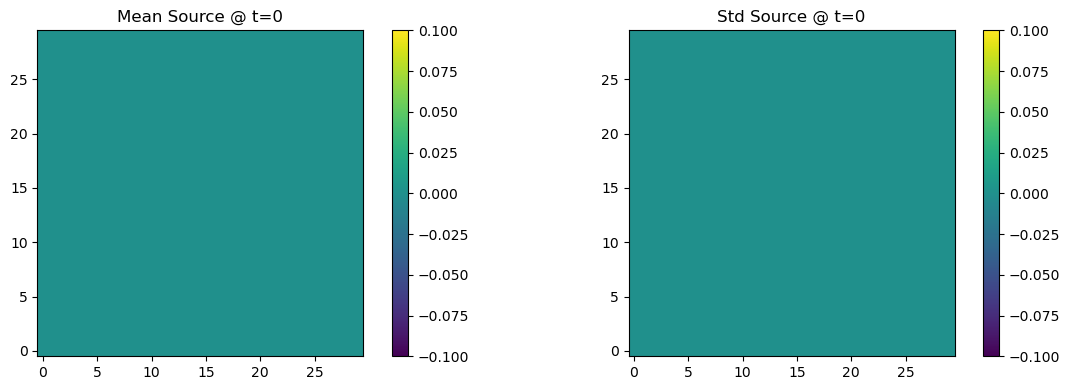

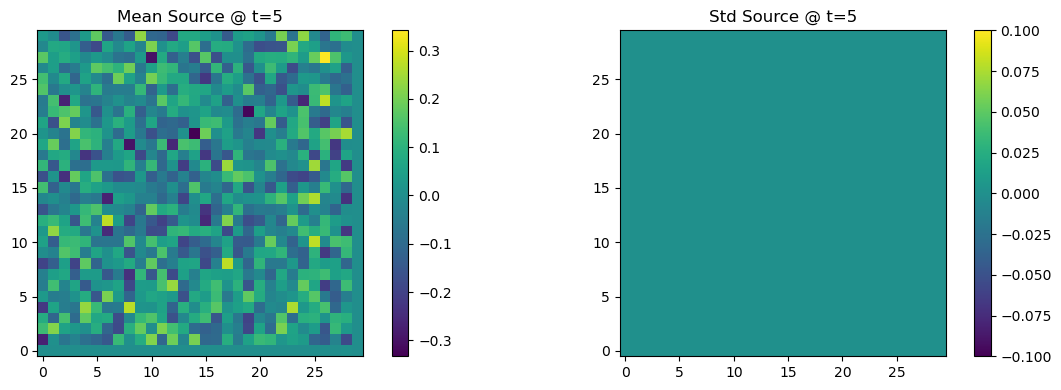

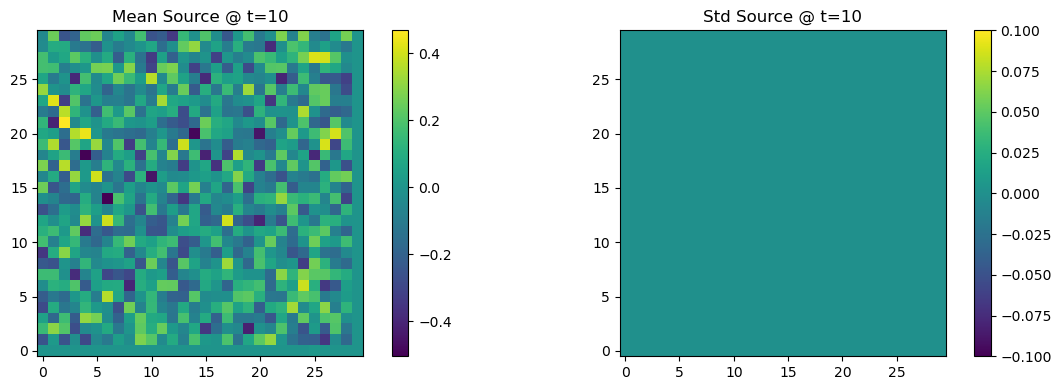

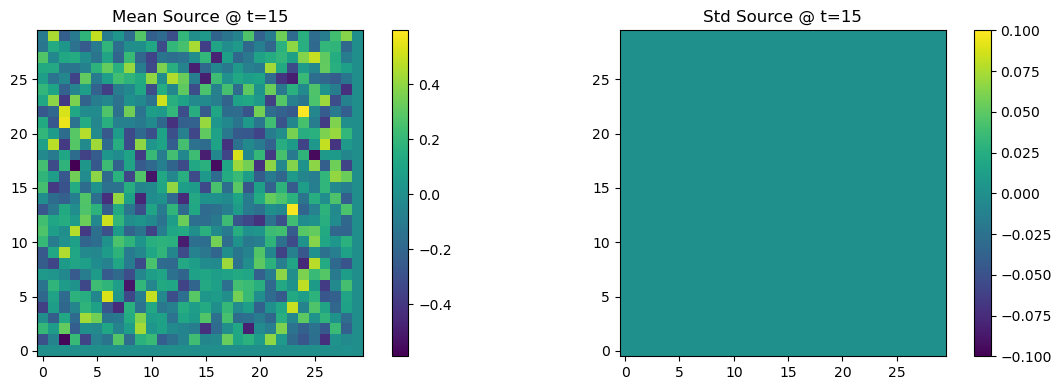

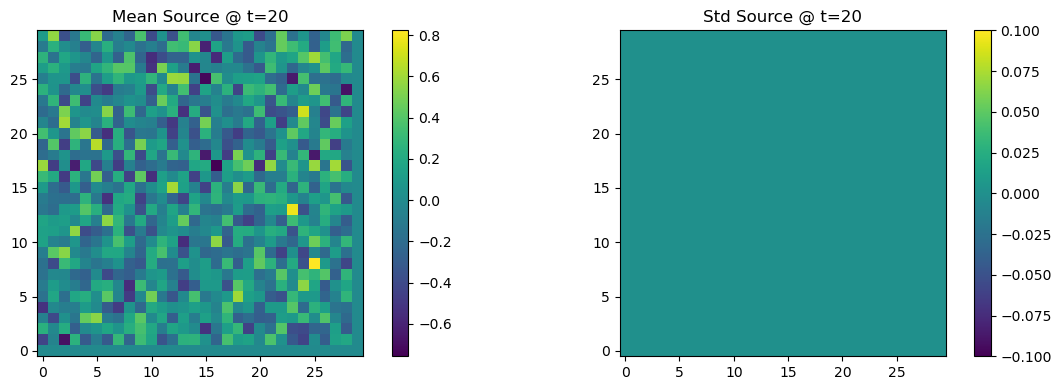

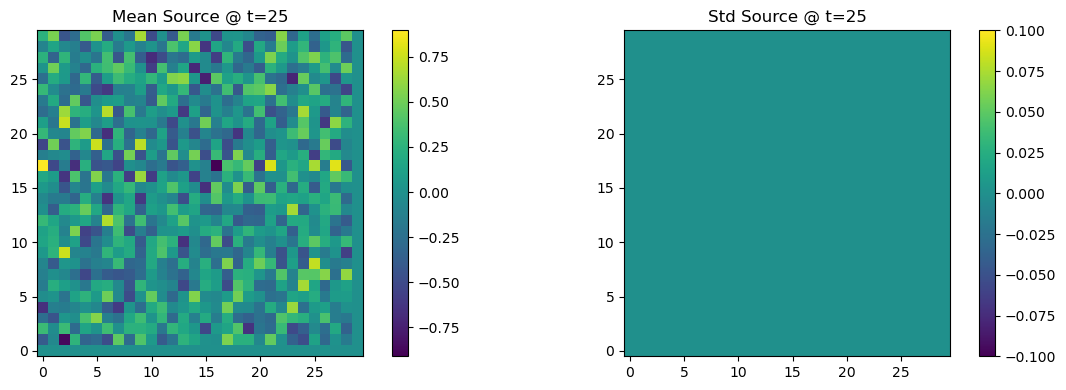

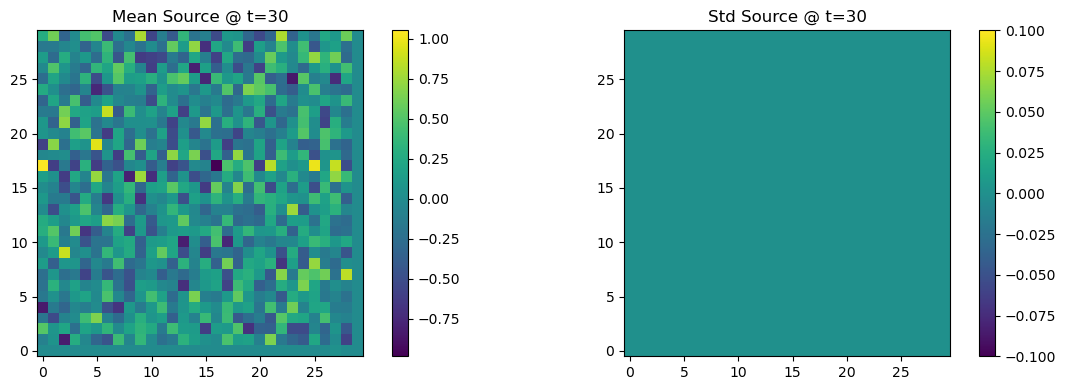

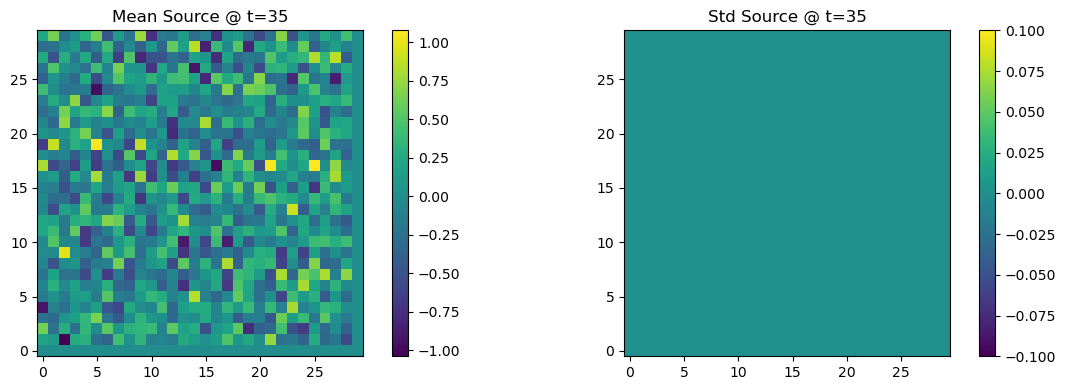

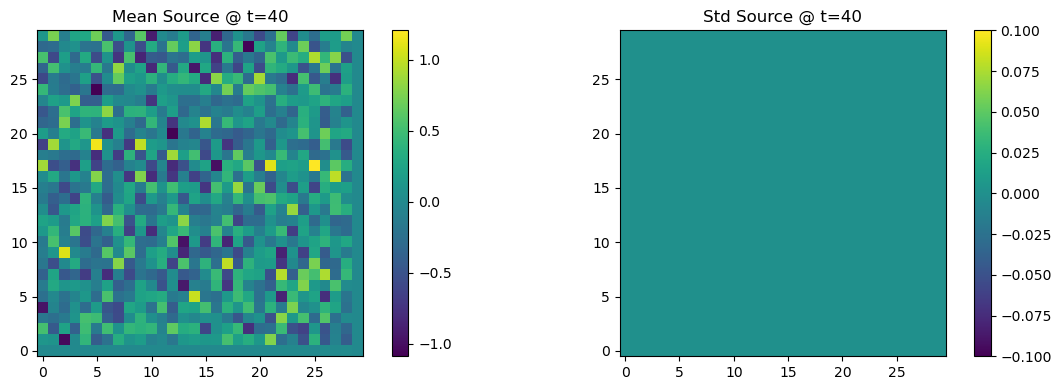

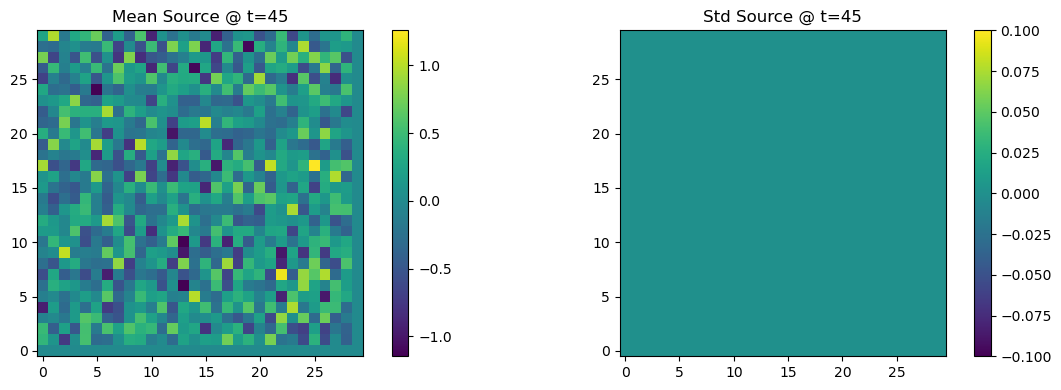

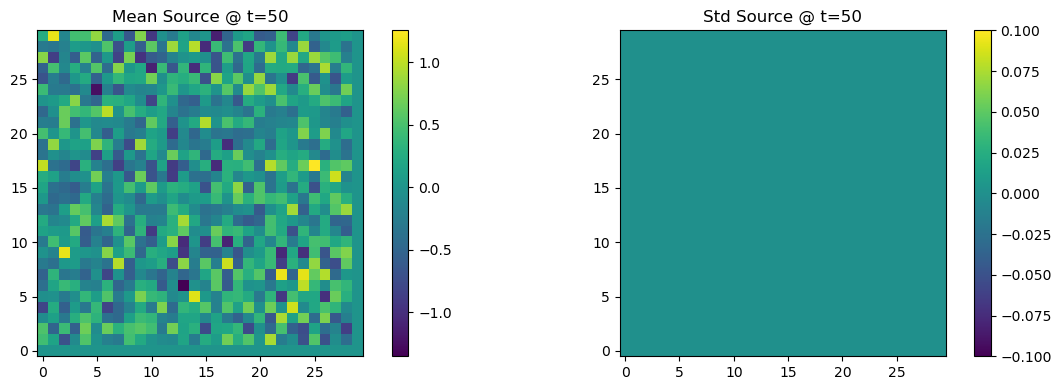

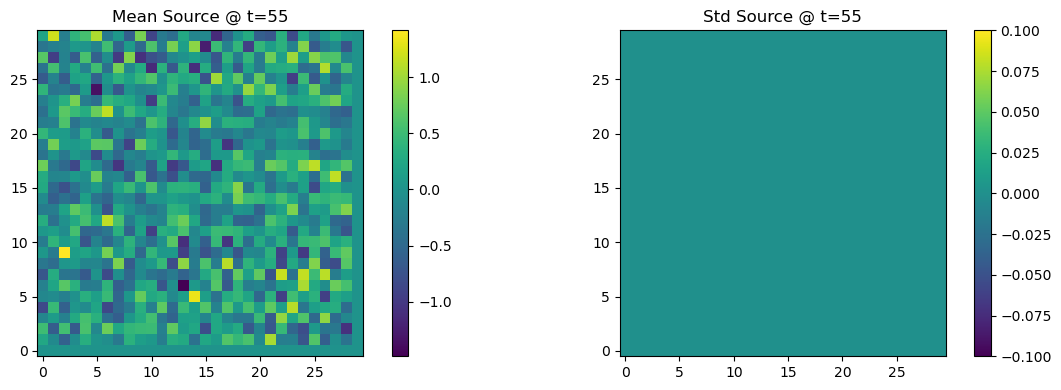

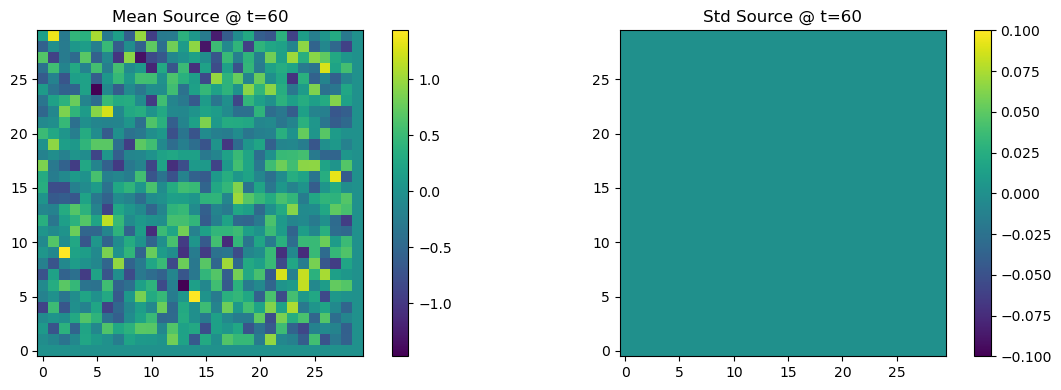

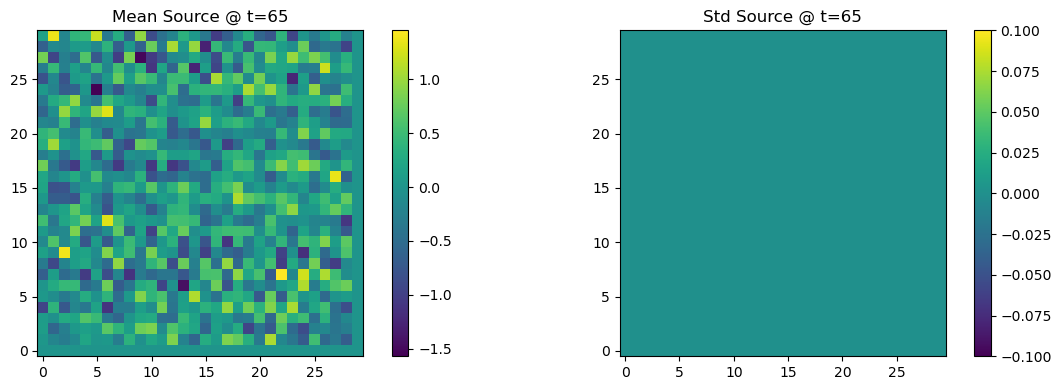

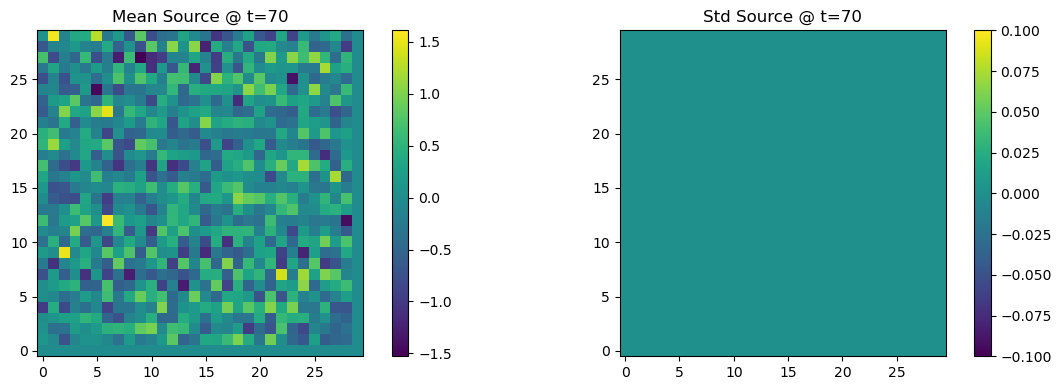

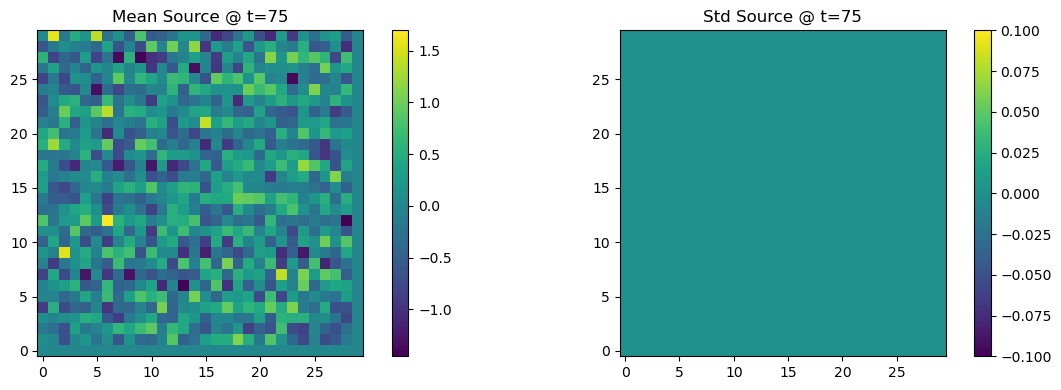

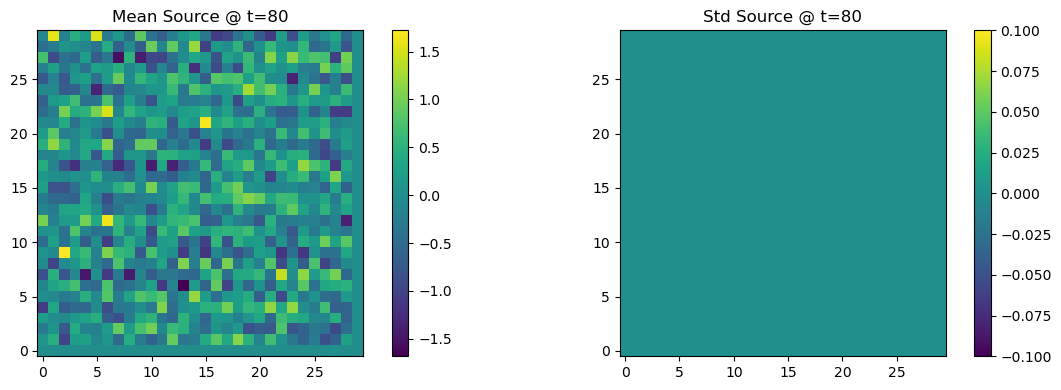

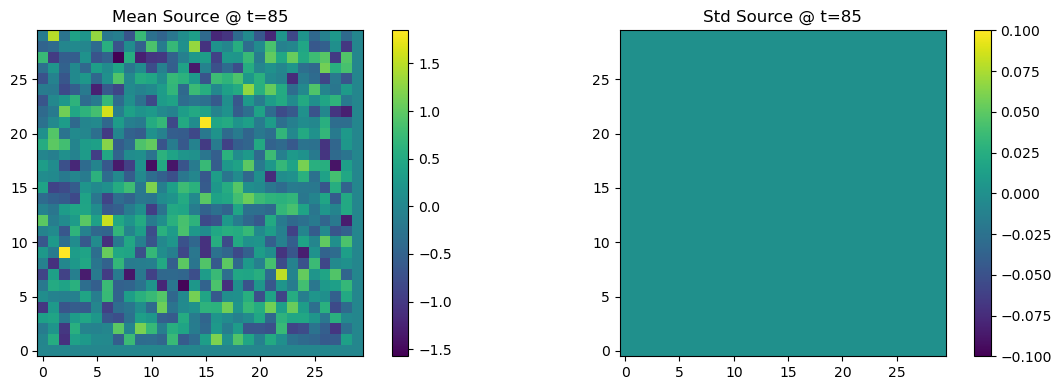

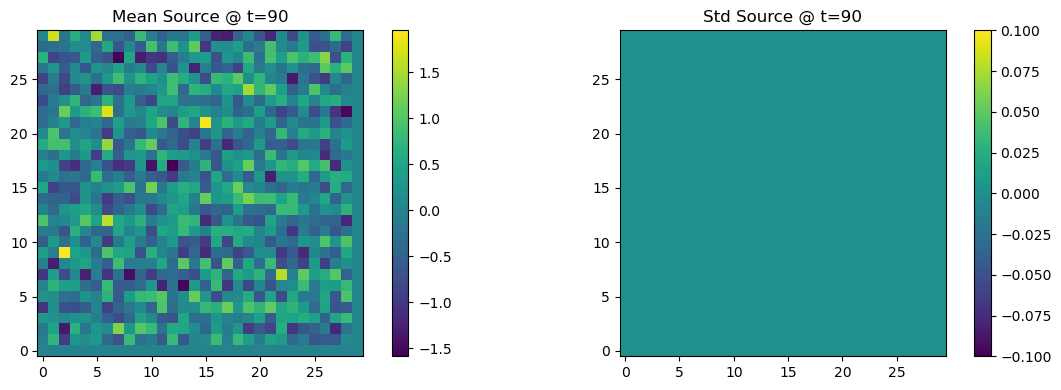

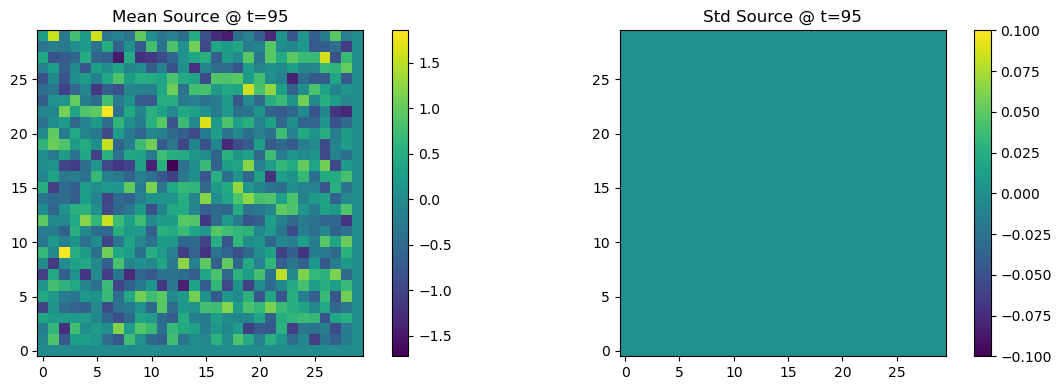

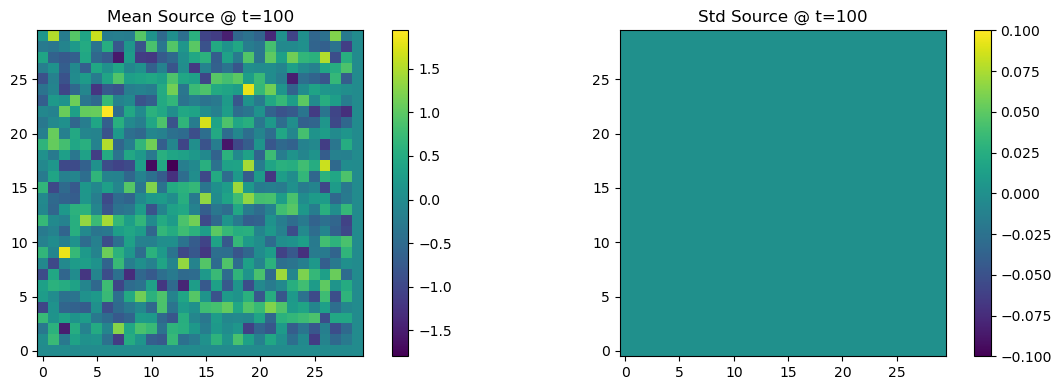

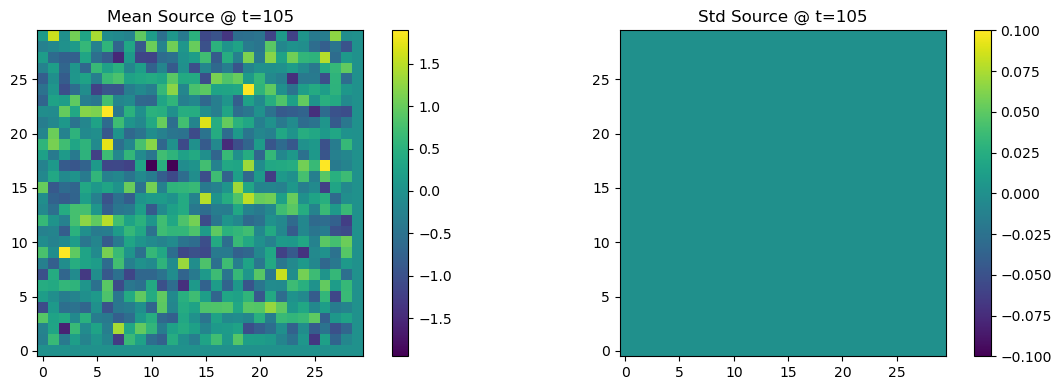

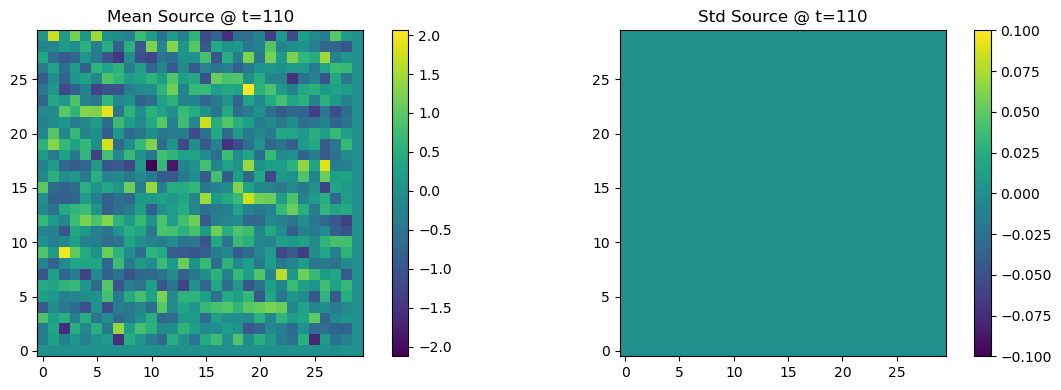

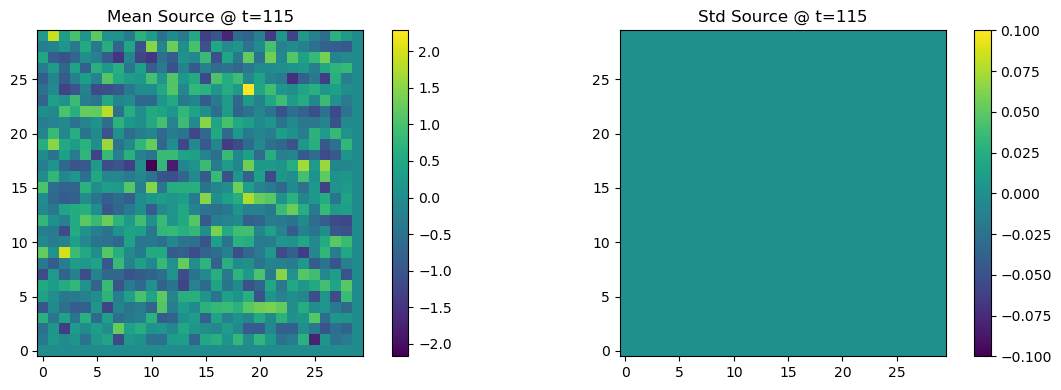

In [1]:
from pyproj import Proj
import numpy as np
from scipy.stats import norm
from advectionGP.kernels import EQ
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.wind import WindSimple, RealWindBinned, RealWindNearestNeighbour, RealWindHybrid, FastWindGrid
from advectionGP.sensors import RemoteSensingModel
from advectionGPdatasets import proposeboundary
import matplotlib.pyplot as plt
import time

# === Step 1: Define UTM and Spatial Domain ===
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
xmin, ymin = proj(146, -38)
xmax, ymax = proj(148, -36)

# === Step 2: Generate Observation Locations ===
# Create evenly spaced 5 x-centers and 10 y-centers in UTM space
x_centers = np.linspace(xmin, xmax, 5)
y_centers = np.linspace(ymin, ymax, 10)

# Set time range for each observation (last 3 hours of the day)
t_start, t_end = 600, 1440
sensors = RemoteSensingModel(num_particles=3)
# Generate obsLocs as [t_start, t_end, x, y] combinations (shape = 50, 4)
obsLocs = []
for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    obsLocs.append([t_start, t_end, x, y])

obsLocs = np.array(obsLocs)

boundary = proposeboundary(obsLocs)
padding = 50000
boundary = (np.array(boundary[0]), np.array(boundary[1]))
boundary[0][1:] -= padding
boundary[1][1:] += padding

# === Step 3: Sensor Model (no longer needs getHs) ===
# sensors = RemoteSensingModel(num_particles=10)

# === Step 4: Setup Kernel & Wind ===
N_feat = 1500
k = EQ(10, 1)
res = [120, 30, 30]
noiseSD = 0.001
k_0 = 0.5
windmodel4 = FastWindGrid(start_date="2019-10-01", num_days=1)
# windmodel = WindSimple(1, 1)

# === Step 5: Initialize Mesh-Free Model ===
mInfer = Model(
    resolution=res,
    boundary=boundary,
    N_feat=N_feat,
    noiseSD=noiseSD,
    kernel=k,
    sensormodel=sensors,
    windmodel=windmodel4,
    k_0=k_0
)

# === Step 6: Generate Regressor Matrix ===
start_time = time.time()
mInfer.computeModelRegressors()
num_obs = mInfer.X.shape[1]
regressor_time = time.time()
print(f"[⏱️] Time to computeModelRegressors(): {regressor_time - start_time:.2f} seconds")

# === Step 7: Generate Synthetic Observations ===
def generate_Y_from_obsLocs(obsLocs, centre_x, centre_y, D=2e7):
    Y = []
    for t_start, t_end, x, y in obsLocs:
        t = (t_start + t_end) / 2.0
        d = np.linalg.norm([x - centre_x, y - centre_y])
        
        # Clip blobsize to avoid extreme values
        blobsize = np.sqrt(2 * 2 * D * (t + 4))
        blobsize = np.clip(blobsize, 1, 1e6)
        
        try:
            spatial = norm(0, blobsize).pdf(d)
            temporal = norm(600, 300).cdf(t)  # Change from norm(10,1) to something meaningful
            v = 1000 * spatial * temporal / blobsize
        except:
            v = 0.0  # fallback if anything breaks
        
        if not np.isfinite(v):  # guard against nan/inf
            v = 0.0
        Y.append(v)
    
    return np.array(Y)


centre_x = (xmin + xmax) / 2
centre_y = (ymin + ymax) / 2
Y = generate_Y_from_obsLocs(obsLocs[:num_obs], centre_x, centre_y, D=2e7)
Y = Y.reshape(-1)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
# === Step 8: Inference ===
meanZ, covZ = mInfer.computeZDistribution(Y)
inference_time = time.time()
print(f"[⏱️] Time to computeZDistribution(): {inference_time - regressor_time:.2f} seconds")

# === Step 9: Grid Setup for Visualization ===
t_vals = np.linspace(boundary[0][0], boundary[1][0], res[0])
x_vals = np.linspace(boundary[0][1], boundary[1][1], res[1])
y_vals = np.linspace(boundary[0][2], boundary[1][2], res[2])
coords = np.stack(np.meshgrid(t_vals, x_vals, y_vals, indexing='ij'), axis=-1)
coords = coords.reshape(-1, 3)

# === Step 10: Forward Simulation ===
sourcemean, sourcevar, all_samples = mInfer.computeConcentration(
    meanZ=meanZ,
    covZ=covZ,
    Nsamps=1,
    Nparticles=5,
    coords=coords,
    interpolateSource=True
)
forward_time = time.time()
print(f"[⏱️] Time to computeConcentration(): {forward_time - inference_time:.2f} seconds")
# === Total Pipeline Timing ===
print(f"[✅] Total source inference pipeline took {forward_time - start_time:.2f} seconds")

# === Step 11: Plotting ===
sourcemean = sourcemean.reshape(res)
sourcevar = sourcevar.reshape(res)
total_time_seconds = boundary[1][0] - boundary[0][0]
dt_seconds = total_time_seconds / res[0]
step_interval = int(10800 / dt_seconds)

for t_index in range(0, res[0], 5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Mean Source @ t={t_index}")
    plt.imshow(sourcemean[t_index], origin='lower')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"Std Source @ t={t_index}")
    plt.imshow(np.sqrt(sourcevar[t_index]), origin='lower')
    plt.colorbar()
    plt.tight_layout()
    plt.show()



In [ ]:
import time
from advectionGP.sensors import RemoteSensingModel
# Generate test particles (example: shape [N_particles, N_obs, 3])
# Let's say you have a sensors class or random dummy input
sensors = RemoteSensingModel()
particles = sensors.genParticles(30)  # or np.random.randn(5, 120, 3) with proper values

# Test RealWind version 1
start_time = time.time()
wind1 = windmodel.getwind(particles)
elapsed_1 = time.time() - start_time
print(f"⏱️ Version 1 getwind() took {elapsed_1:.4f} seconds")

if np.isnan(wind_1).any():
    print("❌ NaNs found in wind_1!")
    nan_indices = np.argwhere(np.isnan(wind_1))
    print(f"NaN at indices:\n{nan_indices[:10]} ...")  # show only first 10
else:
    print("✅ No NaNs in wind_1!")

if np.isinf(wind_1).any():
    print("❌ Inf values found in wind_1!")

# Test RealWind version 2
start_time = time.time()
wind2 = windmodel2.getwind(particles)
elapsed_2 = time.time() - start_time
print(f"⏱️ Version 2 getwind() took {elapsed_2:.4f} seconds")

if np.isnan(wind_2).any():
    print("❌ NaNs found in wind_2!")
    nan_indices = np.argwhere(np.isnan(wind_2))
    print(f"NaN at indices:\n{nan_indices[:10]} ...")  # show only first 10
else:
    print("✅ No NaNs in wind_2!")

if np.isinf(wind_2).any():
    print("❌ Inf values found in wind_2!")

# Test RealWind version 2
start_time = time.time()
wind3 = windmodel3.getwind(particles)
elapsed_3 = time.time() - start_time
print(f"⏱️ Version 3 getwind() took {elapsed_3:.4f} seconds")

if np.isnan(wind_3).any():
    print("❌ NaNs found in wind_3!")
    nan_indices = np.argwhere(np.isnan(wind_3))
    print(f"NaN at indices:\n{nan_indices[:10]} ...")  # show only first 10
else:
    print("✅ No NaNs in wind_2!")

if np.isinf(wind_3).any():
    print("❌ Inf values found in wind_2!")

